# Library

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# Others
import shutil
import random

# Load dataset

In [4]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Corn/train",
    label_mode="categorical",
    class_names=['Corn Gray leaf spot','Corn healthy','Corn leaf blight','Corn rust leaf'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Corn/valid",
    label_mode="categorical",
    class_names=['Corn Gray leaf spot','Corn healthy','Corn leaf blight','Corn rust leaf'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 7665 files belonging to 4 classes.
==========================Validation Data====================
Found 1855 files belonging to 4 classes.


In [6]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale = 1.0/256.)
test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("Dataset/Corn/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("Dataset/Corn/valid",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 7665 images belonging to 4 classes.
Found 1855 images belonging to 4 classes.


# List Resource

In [7]:
# Check GPU
!nvidia-smi

Thu May 25 10:42:57 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.79                 Driver Version: 531.79       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 L...  WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   51C    P8               16W /  N/A|   4574MiB /  6144MiB |      8%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [8]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Modelling Without Augmentation

## MobileNetV2 Model 1

In [10]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Corn_MobileNetV2_model1_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [11]:
# Define DIY Model
MobileNetV2_model = tf.keras.models.Sequential([
    # MobileNetV2 Layer
    MobileNetV2(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
MobileNetV2_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
MobileNetV2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 2,586,948
Trainable params: 2,552,836
Non-

In [12]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_MobileNetV2_model_1 = MobileNetV2_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
384/384 [==============================] - ETA: 0s - loss: 0.4349 - accuracy: 0.9012
Epoch 1: val_accuracy improved from -inf to 0.26307, saving model to Corn_MobileNetV2_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Non_Augmented\assets


384/384 [==============================] - 68s 159ms/step - loss: 0.4349 - accuracy: 0.9012 - val_loss: 7.8253 - val_accuracy: 0.2631 - lr: 0.0010
Epoch 2/100
384/384 [==============================] - ETA: 0s - loss: 0.1608 - accuracy: 0.9457
Epoch 2: val_accuracy improved from 0.26307 to 0.43235, saving model to Corn_MobileNetV2_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Non_Augmented\assets


384/384 [==============================] - 60s 155ms/step - loss: 0.1608 - accuracy: 0.9457 - val_loss: 3.6986 - val_accuracy: 0.4323 - lr: 0.0010
Epoch 3/100
384/384 [==============================] - ETA: 0s - loss: 0.1397 - accuracy: 0.9533
Epoch 3: val_accuracy improved from 0.43235 to 0.81402, saving model to Corn_MobileNetV2_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Non_Augmented\assets


384/384 [==============================] - 59s 154ms/step - loss: 0.1397 - accuracy: 0.9533 - val_loss: 0.7335 - val_accuracy: 0.8140 - lr: 0.0010
Epoch 4/100
384/384 [==============================] - ETA: 0s - loss: 0.1516 - accuracy: 0.9507
Epoch 4: val_accuracy did not improve from 0.81402
384/384 [==============================] - 43s 112ms/step - loss: 0.1516 - accuracy: 0.9507 - val_loss: 4.2212 - val_accuracy: 0.4642 - lr: 0.0010
Epoch 5/100
384/384 [==============================] - ETA: 0s - loss: 0.1278 - accuracy: 0.9562
Epoch 5: val_accuracy improved from 0.81402 to 0.88895, saving model to Corn_MobileNetV2_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Non_Augmented\assets


384/384 [==============================] - 61s 158ms/step - loss: 0.1278 - accuracy: 0.9562 - val_loss: 0.4284 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 6/100
384/384 [==============================] - ETA: 0s - loss: 0.1136 - accuracy: 0.9618
Epoch 6: val_accuracy did not improve from 0.88895
384/384 [==============================] - 43s 111ms/step - loss: 0.1136 - accuracy: 0.9618 - val_loss: 3.1642 - val_accuracy: 0.4259 - lr: 0.0010
Epoch 7/100
384/384 [==============================] - ETA: 0s - loss: 0.1383 - accuracy: 0.9538
Epoch 7: val_accuracy did not improve from 0.88895
384/384 [==============================] - 42s 110ms/step - loss: 0.1383 - accuracy: 0.9538 - val_loss: 4.4249 - val_accuracy: 0.3057 - lr: 0.0010
Epoch 8/100
384/384 [==============================] - ETA: 0s - loss: 0.1214 - accuracy: 0.9586
Epoch 8: val_accuracy did not improve from 0.88895
384/384 [==============================] - 43s 113ms/step - loss: 0.1214 - accuracy: 0.9586 - val_loss: 1.0831 - va

INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Non_Augmented\assets


384/384 [==============================] - 61s 160ms/step - loss: 0.0439 - accuracy: 0.9858 - val_loss: 0.1090 - val_accuracy: 0.9704 - lr: 1.0000e-04
Epoch 12/100
384/384 [==============================] - ETA: 0s - loss: 0.0262 - accuracy: 0.9909
Epoch 12: val_accuracy improved from 0.97035 to 0.97574, saving model to Corn_MobileNetV2_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Non_Augmented\assets


384/384 [==============================] - 62s 160ms/step - loss: 0.0262 - accuracy: 0.9909 - val_loss: 0.0715 - val_accuracy: 0.9757 - lr: 1.0000e-04
Epoch 13/100
384/384 [==============================] - ETA: 0s - loss: 0.0250 - accuracy: 0.9914
Epoch 13: val_accuracy improved from 0.97574 to 0.98113, saving model to Corn_MobileNetV2_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Non_Augmented\assets


384/384 [==============================] - 64s 165ms/step - loss: 0.0250 - accuracy: 0.9914 - val_loss: 0.0594 - val_accuracy: 0.9811 - lr: 1.0000e-04
Epoch 14/100
384/384 [==============================] - ETA: 0s - loss: 0.0241 - accuracy: 0.9935
Epoch 14: val_accuracy did not improve from 0.98113
384/384 [==============================] - 44s 115ms/step - loss: 0.0241 - accuracy: 0.9935 - val_loss: 0.0630 - val_accuracy: 0.9784 - lr: 1.0000e-04
Epoch 15/100
384/384 [==============================] - ETA: 0s - loss: 0.0181 - accuracy: 0.9941
Epoch 15: val_accuracy improved from 0.98113 to 0.98329, saving model to Corn_MobileNetV2_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Non_Augmented\assets


384/384 [==============================] - 61s 158ms/step - loss: 0.0181 - accuracy: 0.9941 - val_loss: 0.0560 - val_accuracy: 0.9833 - lr: 1.0000e-04
Epoch 16/100
384/384 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.9962
Epoch 16: val_accuracy did not improve from 0.98329
384/384 [==============================] - 47s 121ms/step - loss: 0.0107 - accuracy: 0.9962 - val_loss: 0.0650 - val_accuracy: 0.9833 - lr: 1.0000e-04
Epoch 17/100
384/384 [==============================] - ETA: 0s - loss: 0.0066 - accuracy: 0.9980
Epoch 17: val_accuracy improved from 0.98329 to 0.98437, saving model to Corn_MobileNetV2_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Non_Augmented\assets


384/384 [==============================] - 62s 162ms/step - loss: 0.0066 - accuracy: 0.9980 - val_loss: 0.0735 - val_accuracy: 0.9844 - lr: 1.0000e-04
Epoch 18/100
384/384 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 0.9971
Epoch 18: val_accuracy improved from 0.98437 to 0.98491, saving model to Corn_MobileNetV2_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Non_Augmented\assets


384/384 [==============================] - 61s 159ms/step - loss: 0.0103 - accuracy: 0.9971 - val_loss: 0.0718 - val_accuracy: 0.9849 - lr: 1.0000e-04
Epoch 19/100
384/384 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.9970
Epoch 19: val_accuracy did not improve from 0.98491
384/384 [==============================] - 44s 115ms/step - loss: 0.0107 - accuracy: 0.9970 - val_loss: 0.0870 - val_accuracy: 0.9817 - lr: 1.0000e-04
Epoch 20/100
384/384 [==============================] - ETA: 0s - loss: 0.0113 - accuracy: 0.9974
Epoch 20: val_accuracy did not improve from 0.98491

Epoch 20: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
384/384 [==============================] - 44s 114ms/step - loss: 0.0113 - accuracy: 0.9974 - val_loss: 0.0803 - val_accuracy: 0.9822 - lr: 1.0000e-04
Epoch 21/100
384/384 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 0.9993
Epoch 21: val_accuracy did not improve from 0.98491
384/384 [=========

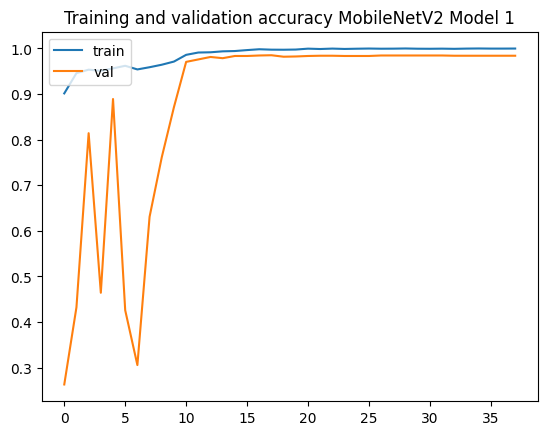

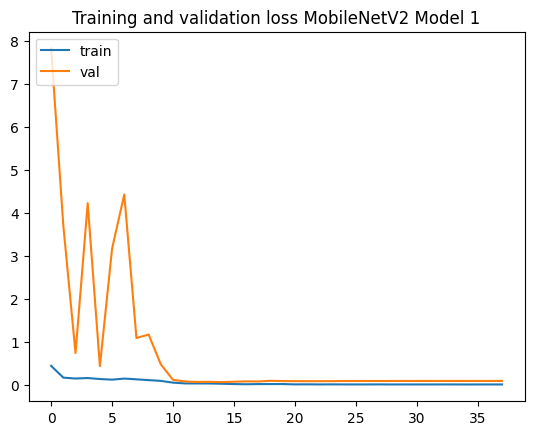

In [13]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_MobileNetV2_model_1.history['accuracy' ]
val_acc  = history_MobileNetV2_model_1.history['val_accuracy' ]
loss     = history_MobileNetV2_model_1.history['loss' ]
val_loss = history_MobileNetV2_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy MobileNetV2 Model 1')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss MobileNetV2 Model 1')
plt.legend(['train', 'val'], loc='upper left')

## Xception Model 2

In [14]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Corn_MobileNetV2_model2_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [15]:
# Define DIY Model
MobileNetV2_model_2 = tf.keras.models.Sequential([
    # MobileNetV2 Layer
    MobileNetV2(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Average Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
MobileNetV2_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
MobileNetV2_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 2,586,948
Trainable params: 2,552,836
No

In [16]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_MobileNetV2_model_2 = MobileNetV2_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
384/384 [==============================] - ETA: 0s - loss: 0.3107 - accuracy: 0.8968
Epoch 1: val_accuracy improved from -inf to 0.38329, saving model to Corn_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Non_Augmented\assets


384/384 [==============================] - 62s 151ms/step - loss: 0.3107 - accuracy: 0.8968 - val_loss: 9.8284 - val_accuracy: 0.3833 - lr: 0.0010
Epoch 2/100
384/384 [==============================] - ETA: 0s - loss: 0.1859 - accuracy: 0.9365
Epoch 2: val_accuracy improved from 0.38329 to 0.53369, saving model to Corn_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Non_Augmented\assets


384/384 [==============================] - 57s 148ms/step - loss: 0.1859 - accuracy: 0.9365 - val_loss: 5.4556 - val_accuracy: 0.5337 - lr: 0.0010
Epoch 3/100
384/384 [==============================] - ETA: 0s - loss: 0.1207 - accuracy: 0.9547
Epoch 3: val_accuracy did not improve from 0.53369
384/384 [==============================] - 43s 113ms/step - loss: 0.1207 - accuracy: 0.9547 - val_loss: 5.3248 - val_accuracy: 0.5111 - lr: 0.0010
Epoch 4/100
384/384 [==============================] - ETA: 0s - loss: 0.1464 - accuracy: 0.9528
Epoch 4: val_accuracy did not improve from 0.53369
384/384 [==============================] - 44s 113ms/step - loss: 0.1464 - accuracy: 0.9528 - val_loss: 29.4351 - val_accuracy: 0.2668 - lr: 0.0010
Epoch 5/100
384/384 [==============================] - ETA: 0s - loss: 0.1348 - accuracy: 0.9533
Epoch 5: val_accuracy did not improve from 0.53369
384/384 [==============================] - 44s 113ms/step - loss: 0.1348 - accuracy: 0.9533 - val_loss: 9.2558 - v

INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Non_Augmented\assets


384/384 [==============================] - 65s 169ms/step - loss: 0.0942 - accuracy: 0.9676 - val_loss: 3.2242 - val_accuracy: 0.6049 - lr: 0.0010
Epoch 8/100
384/384 [==============================] - ETA: 0s - loss: 0.0949 - accuracy: 0.9665
Epoch 8: val_accuracy improved from 0.60485 to 0.67332, saving model to Corn_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Non_Augmented\assets


384/384 [==============================] - 62s 161ms/step - loss: 0.0949 - accuracy: 0.9665 - val_loss: 1.9162 - val_accuracy: 0.6733 - lr: 0.0010
Epoch 9/100
384/384 [==============================] - ETA: 0s - loss: 0.0750 - accuracy: 0.9760
Epoch 9: val_accuracy improved from 0.67332 to 0.84474, saving model to Corn_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Non_Augmented\assets


384/384 [==============================] - 62s 162ms/step - loss: 0.0750 - accuracy: 0.9760 - val_loss: 0.4919 - val_accuracy: 0.8447 - lr: 0.0010
Epoch 10/100
384/384 [==============================] - ETA: 0s - loss: 0.0813 - accuracy: 0.9735
Epoch 10: val_accuracy did not improve from 0.84474
384/384 [==============================] - 45s 116ms/step - loss: 0.0813 - accuracy: 0.9735 - val_loss: 6.8071 - val_accuracy: 0.6383 - lr: 0.0010
Epoch 11/100
384/384 [==============================] - ETA: 0s - loss: 0.0748 - accuracy: 0.9725
Epoch 11: val_accuracy improved from 0.84474 to 0.88410, saving model to Corn_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Non_Augmented\assets


384/384 [==============================] - 62s 162ms/step - loss: 0.0748 - accuracy: 0.9725 - val_loss: 0.5923 - val_accuracy: 0.8841 - lr: 0.0010
Epoch 12/100
384/384 [==============================] - ETA: 0s - loss: 0.0749 - accuracy: 0.9763
Epoch 12: val_accuracy did not improve from 0.88410
384/384 [==============================] - 44s 115ms/step - loss: 0.0749 - accuracy: 0.9763 - val_loss: 2.4184 - val_accuracy: 0.6280 - lr: 0.0010
Epoch 13/100
384/384 [==============================] - ETA: 0s - loss: 0.0770 - accuracy: 0.9760
Epoch 13: val_accuracy improved from 0.88410 to 0.92938, saving model to Corn_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Non_Augmented\assets


384/384 [==============================] - 67s 175ms/step - loss: 0.0770 - accuracy: 0.9760 - val_loss: 0.3103 - val_accuracy: 0.9294 - lr: 0.0010
Epoch 14/100
384/384 [==============================] - ETA: 0s - loss: 0.0562 - accuracy: 0.9825
Epoch 14: val_accuracy improved from 0.92938 to 0.94879, saving model to Corn_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Non_Augmented\assets


384/384 [==============================] - 69s 178ms/step - loss: 0.0562 - accuracy: 0.9825 - val_loss: 0.1735 - val_accuracy: 0.9488 - lr: 0.0010
Epoch 15/100
384/384 [==============================] - ETA: 0s - loss: 0.0629 - accuracy: 0.9768
Epoch 15: val_accuracy did not improve from 0.94879
384/384 [==============================] - 45s 116ms/step - loss: 0.0629 - accuracy: 0.9768 - val_loss: 0.6504 - val_accuracy: 0.8803 - lr: 0.0010
Epoch 16/100
384/384 [==============================] - ETA: 0s - loss: 0.0699 - accuracy: 0.9769
Epoch 16: val_accuracy did not improve from 0.94879
384/384 [==============================] - 44s 115ms/step - loss: 0.0699 - accuracy: 0.9769 - val_loss: 0.9381 - val_accuracy: 0.6248 - lr: 0.0010
Epoch 17/100
384/384 [==============================] - ETA: 0s - loss: 0.0692 - accuracy: 0.9769
Epoch 17: val_accuracy improved from 0.94879 to 0.95094, saving model to Corn_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Non_Augmented\assets


384/384 [==============================] - 63s 162ms/step - loss: 0.0692 - accuracy: 0.9769 - val_loss: 0.2699 - val_accuracy: 0.9509 - lr: 0.0010
Epoch 18/100
384/384 [==============================] - ETA: 0s - loss: 0.0376 - accuracy: 0.9875
Epoch 18: val_accuracy did not improve from 0.95094
384/384 [==============================] - 45s 116ms/step - loss: 0.0376 - accuracy: 0.9875 - val_loss: 0.3440 - val_accuracy: 0.9337 - lr: 0.0010
Epoch 19/100
384/384 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 0.9830
Epoch 19: val_accuracy did not improve from 0.95094

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
384/384 [==============================] - 45s 116ms/step - loss: 0.0491 - accuracy: 0.9830 - val_loss: 2.1235 - val_accuracy: 0.7057 - lr: 0.0010
Epoch 20/100
384/384 [==============================] - ETA: 0s - loss: 0.0243 - accuracy: 0.9923
Epoch 20: val_accuracy improved from 0.95094 to 0.95903, saving model to Corn_Mobi

INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Non_Augmented\assets


384/384 [==============================] - 63s 165ms/step - loss: 0.0243 - accuracy: 0.9923 - val_loss: 0.1857 - val_accuracy: 0.9590 - lr: 1.0000e-04
Epoch 21/100
384/384 [==============================] - ETA: 0s - loss: 0.0126 - accuracy: 0.9960
Epoch 21: val_accuracy improved from 0.95903 to 0.97520, saving model to Corn_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Non_Augmented\assets


384/384 [==============================] - 62s 161ms/step - loss: 0.0126 - accuracy: 0.9960 - val_loss: 0.1032 - val_accuracy: 0.9752 - lr: 1.0000e-04
Epoch 22/100
384/384 [==============================] - ETA: 0s - loss: 0.0115 - accuracy: 0.9974
Epoch 22: val_accuracy improved from 0.97520 to 0.97736, saving model to Corn_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Non_Augmented\assets


384/384 [==============================] - 63s 164ms/step - loss: 0.0115 - accuracy: 0.9974 - val_loss: 0.0860 - val_accuracy: 0.9774 - lr: 1.0000e-04
Epoch 23/100
384/384 [==============================] - ETA: 0s - loss: 0.0064 - accuracy: 0.9986
Epoch 23: val_accuracy improved from 0.97736 to 0.97790, saving model to Corn_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Non_Augmented\assets


384/384 [==============================] - 65s 168ms/step - loss: 0.0064 - accuracy: 0.9986 - val_loss: 0.0974 - val_accuracy: 0.9779 - lr: 1.0000e-04
Epoch 24/100
384/384 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 0.9991
Epoch 24: val_accuracy improved from 0.97790 to 0.97898, saving model to Corn_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Non_Augmented\assets


384/384 [==============================] - 63s 163ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 0.1004 - val_accuracy: 0.9790 - lr: 1.0000e-04
Epoch 25/100
384/384 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 0.9986
Epoch 25: val_accuracy improved from 0.97898 to 0.98005, saving model to Corn_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Non_Augmented\assets


384/384 [==============================] - 64s 165ms/step - loss: 0.0050 - accuracy: 0.9986 - val_loss: 0.0927 - val_accuracy: 0.9801 - lr: 1.0000e-04
Epoch 26/100
384/384 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 0.9990
Epoch 26: val_accuracy did not improve from 0.98005
384/384 [==============================] - 47s 120ms/step - loss: 0.0038 - accuracy: 0.9990 - val_loss: 0.0956 - val_accuracy: 0.9784 - lr: 1.0000e-04
Epoch 27/100
384/384 [==============================] - ETA: 0s - loss: 0.0069 - accuracy: 0.9984
Epoch 27: val_accuracy did not improve from 0.98005

Epoch 27: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
384/384 [==============================] - 46s 120ms/step - loss: 0.0069 - accuracy: 0.9984 - val_loss: 0.1042 - val_accuracy: 0.9784 - lr: 1.0000e-04
Epoch 28/100
384/384 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 0.9996
Epoch 28: val_accuracy did not improve from 0.98005
384/384 [=========

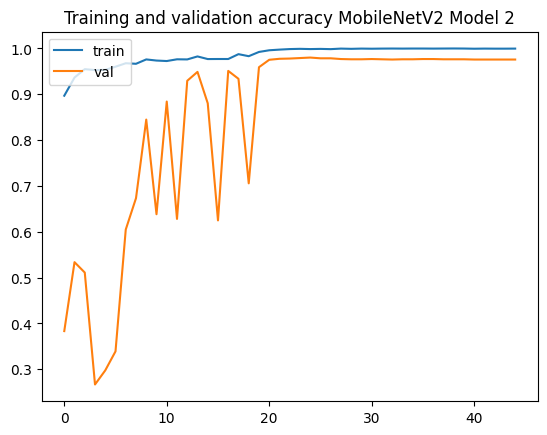

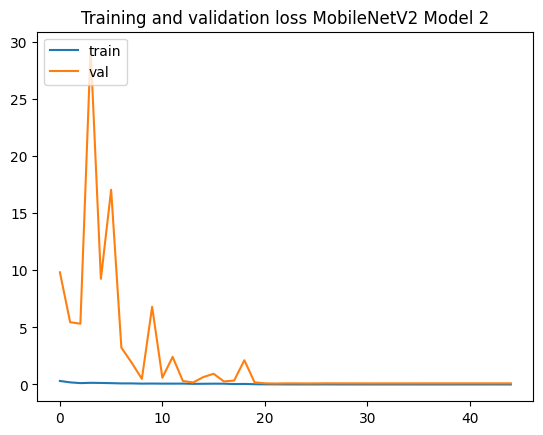

In [17]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_MobileNetV2_model_2.history['accuracy' ]
val_acc  = history_MobileNetV2_model_2.history['val_accuracy' ]
loss     = history_MobileNetV2_model_2.history['loss' ]
val_loss = history_MobileNetV2_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy MobileNetV2 Model 2')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss MobileNetV2 Model 2')
plt.legend(['train', 'val'], loc='upper left')